## 2 Mixtures

In [1]:
import os
import glob
import numpy as np
import pandas as pd

all_files = glob.glob(os.path.join("..", "var", "mixtures old.csv"))

df = pd.concat((pd.read_csv(f, header=None) for f in all_files), ignore_index=True)

In [2]:
df = df.drop_duplicates()

df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.1,0.9,3,1,5,5,3,0,0,2,1.52,1.1,1.1,1.52,1.0
1,0.1,0.9,3,1,5,5,3,0,0,3,1.52,1.1,1.1,1.52,1.0
2,0.1,0.9,3,2,3,3,1,0,0,1,1.52,1.1,1.1,1.52,1.0
3,0.1,0.9,3,2,3,3,1,0,0,2,1.52,1.1,1.1,1.52,1.0
4,0.1,0.9,3,2,3,3,1,0,0,3,1.52,1.1,1.1,1.52,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14334,0.9,0.1,3,3,5,5,2,0,0,2,1.52,1.1,1.1,1.52,1.0
14335,0.9,0.1,3,3,5,5,2,0,0,3,1.52,1.1,1.1,1.52,1.0
14336,0.9,0.1,3,3,5,5,3,0,0,1,1.52,1.1,1.1,1.52,1.0
14337,0.9,0.1,3,3,5,5,3,0,0,2,1.52,1.1,1.1,1.52,1.0


In [3]:
df = df.drop(df[df[14] == 1].sample(frac=.97).index)

<AxesSubplot:>

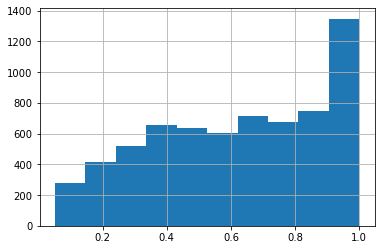

In [4]:
df[14].hist()

In [5]:
y = df[range(0, 14)].to_numpy()
X = df[14].to_numpy().reshape(-1, 1)

In [6]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
batch_size = 64

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [8]:
from torch import nn
from torch import optim
from moebius import olr_from_flat
from moebius.model.gmm.nn import ParameterGenerator

input_dim = 1
hidden_dim = 100
output_dim = y.shape[1]
       
model = ParameterGenerator(input_dim, hidden_dim, output_dim, 2)
print(model)

ParameterGenerator(
  (layer1): Linear(in_features=1, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=100, bias=True)
  (layer5): Linear(in_features=100, out_features=14, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=1)
)


In [9]:
learning_rate = 1e-5

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
from tqdm import tqdm

num_epochs = 200
loss_values = []

for epoch in tqdm(range(num_epochs)):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


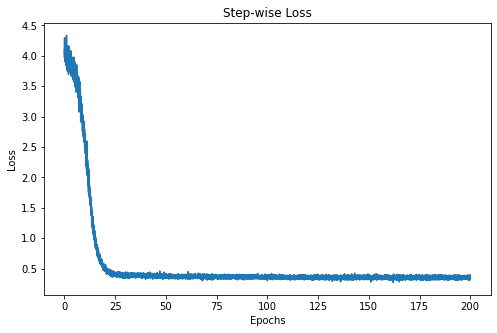

In [11]:
import matplotlib.pyplot as plt

step = np.linspace(0, num_epochs, len(loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [12]:
min(loss_values)

0.2739469110965729

In [13]:
i = 0
mse = 0
total = 0

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)

        # print(outputs[0])
        # print(X[0], olr_from_plain(outputs[0]))

        # break

        # print(outputs.shape)

        for i, output in enumerate(outputs):
            true = X[i][0].item()
            predicted_params = outputs[i]
            predicted_olr = olr_from_flat(2, 2, predicted_params)
            predicted_olr = predicted_olr[0] if isinstance(predicted_olr, list) else predicted_olr

            predicted_olr = predicted_olr.item() if torch.is_tensor(predicted_olr) else predicted_olr

#             print(predicted_olr)
#             print(true)
#             print(predicted_params)

            # predicted_olr -= 0.15

            mse += (true - predicted_olr) ** 2
            total += 1

            # if total >= 10:
            #   break

        break

print(mse / total)

0.05470613917530892


In [14]:
model.save(os.path.join('..', 'var', 'models', 'gmm_2.pth'))

## 3 Mixtures

In [15]:
df_3 = pd.read_csv(os.path.join("..", "var", "mixtures_3.csv"), header=None)

In [16]:
df_3 = df_3.drop_duplicates()

df_3

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.1,0.1,0.8,0,0,3,3,3,3,1,...,1.1,1.1,1.52,1.52,1.1,1.1,1.52,0.523176,1.0,1.0
1,0.1,0.1,0.8,0,0,3,3,3,3,1,...,1.1,1.1,1.52,1.52,1.1,1.1,1.52,0.695583,1.0,1.0
2,0.1,0.1,0.8,0,0,3,3,3,3,1,...,1.1,1.1,1.52,1.52,1.1,1.1,1.52,0.812421,1.0,1.0
3,0.1,0.1,0.8,0,0,3,3,3,3,2,...,1.1,1.1,1.52,1.52,1.1,1.1,1.52,0.695583,1.0,1.0
4,0.1,0.1,0.8,0,0,3,3,3,3,2,...,1.1,1.1,1.52,1.52,1.1,1.1,1.52,0.948223,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431563,0.8,0.1,0.1,3,3,5,5,5,5,2,...,1.1,1.1,1.52,1.52,1.1,1.1,1.52,1.000000,1.0,1.0
431564,0.8,0.1,0.1,3,3,5,5,5,5,2,...,1.1,1.1,1.52,1.52,1.1,1.1,1.52,1.000000,1.0,1.0
431565,0.8,0.1,0.1,3,3,5,5,5,5,3,...,1.1,1.1,1.52,1.52,1.1,1.1,1.52,1.000000,1.0,1.0
431566,0.8,0.1,0.1,3,3,5,5,5,5,3,...,1.1,1.1,1.52,1.52,1.1,1.1,1.52,1.000000,1.0,1.0


In [17]:
df_3 = df_3.drop(df_3[df_3[21] == 1].sample(frac=.999).index)
df_3 = df_3.drop(df_3[df_3[22] == 1].sample(frac=.999).index)
df_3 = df_3.drop(df_3[df_3[23] == 1].sample(frac=.999).index)

<AxesSubplot:>

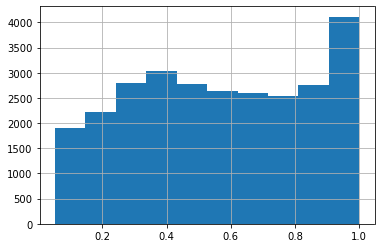

In [18]:
df_3[21].hist()

In [19]:
y = df_3[range(0, 21)].to_numpy()
X = df_3[range(21, 24)].to_numpy()

In [20]:
batch_size = 64

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [21]:
input_dim = 3
hidden_dim = 100
output_dim = y.shape[1]

model = ParameterGenerator(input_dim, hidden_dim, output_dim, 3)
print(model)

ParameterGenerator(
  (layer1): Linear(in_features=3, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=100, bias=True)
  (layer5): Linear(in_features=100, out_features=21, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=1)
)


In [22]:
learning_rate = 1e-5

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
from tqdm import tqdm

num_epochs = 200
loss_values = []

for epoch in tqdm(range(num_epochs)):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

100%|██████████| 200/200 [01:11<00:00,  2.81it/s]


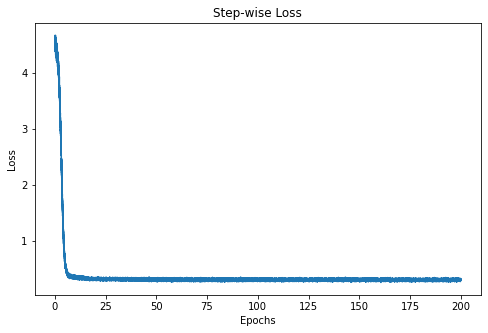

In [24]:
import matplotlib.pyplot as plt

step = np.linspace(0, num_epochs, len(loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [25]:
min(loss_values)

0.2519928216934204

In [26]:
def olr_from_plain_3(x):
    return olr([x[0],  x[1], x[2]],  [[x[3],  x[4]],  [x[5],
         x[6]], [x[7], x[8]]],  [[[x[9], x[10]],  [x[11],  x[12]]],
         [[x[13],  x[14]],  [x[15], x[16]]], [[x[17], x[18]], [x[19], x[20]]]])

In [40]:
i = 0
mse = 0
total = 0

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)

        # print(outputs[0])
        # print(X[0], olr_from_plain(outputs[0]))

        # break

        # print(outputs.shape)

        for i, output in enumerate(outputs):
            predicted_params = outputs[i]
            predicted_olr = olr_from_flat(3, 2, predicted_params)

#             print('predicted: ' + str(predicted_olr) + ', true: ' + str(X[i].numpy()))
            
#             print(str(predicted_olr) + ' ' + str(true))
#             print(predicted_olr)
#             print(true)
#             print(predicted_params)

            # predicted_olr -= 0.15

            mse += (np.array(predicted_olr) - X[i].numpy()) ** 2
            total += 1

            # if total >= 10:
            #   break

        break

print(mse / total)

[0.09663966 0.07011225 0.14815975]


In [30]:
model.save(os.path.join('..', 'var', 'models', 'gmm_3.pth'))